# MovieLens 100k data set exploration

This notebook has the objective of visualizing and exploring the information stored in the MovieLens 100k [http://www.movielens.org/] data set provided by the GroupLens Project [http://www.grouplens.org/] in 1998

    Herlocker, J., Konstan, J., Borchers, A., Riedl, J.. An Algorithmic
    Framework for Performing Collaborative Filtering. Proceedings of the
    1999 Conference on Research and Development in Information
    Retrieval. Aug. 1999.



In [31]:
import numpy as np
import pandas as pd
import torch as th
import os
from datetime import timedelta
from datetime import datetime
import requests
%matplotlib inline 
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
import seaborn as sns
import itertools as it


# Download Data
The information used inside this notebook is stored locally in a 'data' folder, two parent directories up

In [32]:
data_dir='./data/ml-100k/raw/ml-100k'
assert os.listdir(data_dir)==['u4.test', 'u3.test', 'u3.base', 'ub.base', 'README', 'u2.test', 'ub.test', 'u.occupation', 'u.user', 'u.item', 'ua.test', 'u4.base', 'u.data', 'u1.test', 'u1.base', 'allbut.pl', 'u.info', 'mku.sh', 'u.genre', 'u5.base', 'u5.test', 'u2.base', 'ua.base']


In [33]:
# Some code to download the data to the specified directory if it does not already exist yet

if os.path.exists(data_dir) == False:
    cwd=os.getcwd()
    os.chdir(data_dir)
    url='https://files.grouplens.org/datasets/movielens/ml-100k.zip'
    print('\r','Downloading Started', end='')
    # Downloading the file by sending the request to the URL
    req = requests.get(url)
    # Split URL to get the file name
    filename = url.split('/')[-1]
    download_path=os.getcwd()+'/'+filename
    print('\r',f'saving zip to {download_path}', end='\n')
    # Writing the file to the local file system
    with open(download_path,'wb') as output_file:
        output_file.write(req.content)
        os.system(f'unzip ml-100k.zip')
    print('\r','Downloading Completed', end='\n')
    os.chdir(cwd)

# Load DataFrames

There are several smaller collections of information stored in the ML100k dataset. Each can be loaded into memory utilizing the pandas library

1. ratings_df
    - the user movie interaction data
2. info_df 
    - the count measurements of the data set
3. genre_df
    - the genre name and id mapping
4. occupation_df
    -  the occupation name and id mapping
5. item_df
    - the movie infomation data
6. user_df
    - the user information data

In [34]:
# ratings data
columns_name=['user_id','item_id','rating','timestamp']
ratings_df = pd.read_csv(f"{data_dir}/u.data",sep="\t",names=columns_name)

# data info
info_df = pd.read_csv(f"{data_dir}/u.info", sep=" ", header=None)
info_df.columns=['Counts', 'Type']

# movie genres
column_names=['genre', 'genre_id']
genre_df = pd.read_csv(f"{data_dir}/u.genre", sep="|", encoding='latin-1', header=None, names=column_names)

#occupation data
occupation_df = pd.read_csv(f"{data_dir}/u.occupation", sep="|", encoding='latin-1', header=None, names=['occupation'])
occupation_df=occupation_df.reset_index().rename(columns={'index': 'occupation_id'})

#item data
column_names = ['movie_id', 'movie_title' ,'release_date','video_release_date', 'IMDb_URL', 'unknown', 'Action', 
                'Adventure', 'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 
                'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
item_df = pd.read_csv(f"{data_dir}/u.item", sep="|", encoding='latin-1', header=None, names=column_names)

#user data
column_names = ['user_id', 'age', 'gender', 'occupation', 'zip_code']
user_df = pd.read_csv(f"{data_dir}/u.user", sep="|", encoding='latin-1', header=None, names=column_names)





# Incorporating additional rating data

In many cases, data sets that offer information on user-item interactions do not provide in depth features for users, since their relations to other tables in the database allow for easy processing. Some examples of additional features that can be added to the items data are:
- day of interaction
- week of interaction
- hour of interaction
- ....

In [35]:
ratings_df['date']=ratings_df['timestamp'].apply(lambda x: datetime.fromtimestamp(x).date())
ratings_df['weekday']=ratings_df['timestamp'].apply(lambda x: datetime.fromtimestamp(x).weekday())
ratings_df['time']=ratings_df['timestamp'].apply(lambda x: datetime.fromtimestamp(x).time())
ratings_df['hour']=ratings_df['time'].apply(lambda x: x.hour)

# Incorporating additional user data

In many cases, data sets that offer information on user-item interactions do not provide in depth features for users, since their relations to other tables in the database allow for easy processing. Some examples of additional features that can be added to the users data are:
- the avg user rating
- binning the user age
- ....


In [36]:
user_rating_counts=ratings_df['user_id'].value_counts().to_dict()
avg_ratings = []
interaction_counts = []
for u_id, rating_count in user_rating_counts.items():
    user_subset=ratings_df[ratings_df['user_id']==u_id]
    avg_ratings.append(sum(user_subset['rating'].values)/rating_count)
    interaction_counts.append(int(user_subset.shape[0]))

user_df['avg_rating'] = avg_ratings
user_df['interactions'] = interaction_counts
user_df['age_by_decade'] = pd.cut(x=user_df['age'], bins=[0, 9, 19, 29, 39, 49, 59, 69, 79, 89, 99], labels=['00s', '10s', '20s', '30s', '40s', '50s', '60s', '70s', '80s', '90s'])



# Incorporating additional item data

In many cases, data sets that offer information on user-item interactions do not provide in depth features for users, since their relations to other tables in the database allow for easy processing. Some examples of additional features that can be added to the items data are:
- the avg item rating
- binning the item age
- ....

# Merging the user, item and rating tables together
The resulting view of the information allows us to preform numerous amounts of pair plots, histograms, and kernel density plots to be used for distributional analysis

In [37]:
rating_user_item_view = ratings_df.join(user_df.set_index('user_id'),on='user_id').join(item_df.set_index('movie_id'),on='item_id')
rating_user_item_view=pd.DataFrame(rating_user_item_view)
rating_user_item_view


,user_id,item_id,rating,timestamp,date,weekday,time,hour,age,gender,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,196,242,3,881250949,1997-12-04,3,16:55:49,16,49,M,...,0,0,0,0,0,0,0,0,0,0
1,186,302,3,891717742,1998-04-04,5,21:22:22,21,39,F,...,0,1,0,0,1,0,0,1,0,0
2,22,377,1,878887116,1997-11-07,4,08:18:36,8,25,M,...,0,0,0,0,0,0,0,0,0,0
3,244,51,2,880606923,1997-11-27,3,06:02:03,6,28,M,...,0,0,0,0,0,1,0,0,1,1
4,166,346,1,886397596,1998-02-02,0,06:33:16,6,47,M,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,880,476,3,880175444,1997-11-22,5,06:10:44,6,13,M,...,0,0,0,0,0,0,0,0,0,0
99996,716,204,5,879795543,1997-11-17,0,20:39:03,20,36,F,...,0,0,0,0,0,0,1,0,0,0
99997,276,1090,1,874795795,1997-09-21,6,00:49:55,0,21,M,...,0,0,0,0,0,0,0,1,0,0
99998,13,225,2,882399156,1997-12-17,2,23:52:36,23,47,M,...,0,0,0,0,0,0,0,0,0,0


# **Statistical tests between distributions separated by a sensitive attributes**

For analyzing if two distributions are statistically different. We can use several statistical tests like...
- Kolmogorov-Smirnov test for goodness of fit
- others are applicable, but starting with just one for now

### Pitfalls of KS-Tests
- Some of the observable pitfalls of the KS-metric, is that the scale is from [0-1].
- When two distributions overlap, and are far apart, the KS-metric == 1
    - however, when two distributions **DO NOT** overlap, and are far apart, the KS-metric == 1

**While this might not be obvious, the KS Metric falls short in measuring the true distributional distance between two samples**

For this reason, the Wasserstein Distance metric can be utilized to sort the pairs of significantly differing distributions, by there distributional distance from each other

### **Performing the (one-sample or two-sample) Kolmogorov-Smirnov test for goodness of fit.**

    scipy.stats.kstest(rvs, cdf, args=(), N=20, alternative='two-sided', method='auto')

The one-sample test compares the underlying distribution F(x) of a sample against a given distribution G(x). The two-sample test compares the underlying distributions of two independent samples. Both tests are valid only for continuous distributions.

In [49]:
from scipy import stats

#### Example

In [50]:
rng = np.random.default_rng()
sample1 = stats.laplace.rvs(size=105, random_state=rng)
sample2 = stats.laplace.rvs(size=95, random_state=rng)
stats.kstest(sample1, sample2)


KstestResult(statistic=0.14586466165413534, pvalue=0.21170968646047655)

In [40]:
#### automated function
def perform_2sided_ks_tests(data: pd.DataFrame, distribution_attr: str, sensitive_attr:str):
    """
    Description:
    perform_ks_tests returns a set of all permutations of the pairs of sensitive attributes,
    and their 2 sample KS statistics of the specified distribution in question

    For a 2-sided KS test, the null hypothesis is that the two distributions are identical, 
    F(x)=G(x) for all x; the alternative is that they are not identical.

    If the p-val < .05 reject the null hypothesis

    Arguments:
    data - pandas Dataframe obj containing both the distribution_attr and the sensitive_attr in the column names
    distribution_attr -  this is a float valued column in the data argument
    sensitive_attr - this is a categorical string valued column in the data argument

    Returns:
    dict() - {(attr_a, attr_b): (k_stat, p_val),...} for all combinations of categories in sensitive attribute column

    """
    results = {}
    sensitive_attr_categories = data[sensitive_attr].unique()
    assert len(sensitive_attr_categories) > 1

    for combination in it.combinations(sensitive_attr_categories, 2):
        (attr_a, attr_b) = combination
        attr_a_data = data[data[sensitive_attr]==attr_a][distribution_attr]
        attr_b_data = data[data[sensitive_attr]==attr_b][distribution_attr]
        results[combination] = stats.kstest(attr_a_data, attr_b_data)

    return results



In [41]:
from math import dist


def get_wasserstein_dist(data, distribution_attr, sensitive_attr, attr_a, attr_b):
    """Description:
    get_wasserstein_dist computes the distributional distance between two samples. 

    Arguments:
    data - pandas Dataframe obj containing both the distribution_attr and the sensitive_attr in the column names
    distribution_attr -  this is a float valued column in the data argument
    sensitive_attr - this is a categorical string valued column in the data argument
    attr_a = string name of the first sample (a sensitive attribute label)
    attr_b = string name of the second sample (a sensitive attribute label)

    Returns:
    distance: Int
    """
    attr_a_data = data[data[sensitive_attr]==attr_a][distribution_attr]
    attr_b_data = data[data[sensitive_attr]==attr_b][distribution_attr]
    distance = stats.wasserstein_distance(attr_a_data, attr_b_data)

    return distance



In [42]:
def analyze_2sided_ks_results(data: pd.DataFrame, distribution_attr: str, sensitive_attr:str):
    """
    Description:
    analyze_2sided_ks_results uses the output from perform_2sided_ks_tests to identify pairs of sensitive attributes,
    of the indicated distribution_attr, that are statistically different. 
    (looks for pairs whose p-val < .05 == reject the null hypothesis)

    Arguments:
    data - pandas Dataframe obj containing both the distribution_attr and the sensitive_attr in the column names
    distribution_attr -  this is a float valued column in the data argument
    sensitive_attr - this is a categorical string valued column in the data argument

    Returns:
    dict() - {(attr_a, attr_b): (k_stat, p_val),...} for all combinations of categories in sensitive attribute column

    """
    output={}
    results = perform_2sided_ks_tests(data, distribution_attr, sensitive_attr)
    
    for (attr_a, attr_b), (k_stat, p_val) in results.items():
        if p_val<.05:
            output[(attr_a, attr_b)]=get_wasserstein_dist(data, distribution_attr, sensitive_attr, attr_a, attr_b)

    return {k: v for k, v in sorted(output.items(), key=lambda item: item[1], reverse=True)}

In [43]:
def analyze_sensitive_attr_distributions(data: pd.DataFrame, distribution_attr_list: list, sensitive_attr_list: list):
    """
    Description:
    analyze_sensitive_attr_distributions is a function that utilizes analyze_2sided_ks_results and perform_2sided_ks_tests
    to extend the opportunities of findings by aggregation all statistically different pairings of sensitive attributes, 
    for all the possible distributions that are given 
    
    Arguments:
    data - pandas Dataframe obj containing both the distribution_attr and the sensitive_attr in the column names
    distribution_attr_list - list of column names
    sensitive_attr_list - list of column names

    Returns:
    
    """
    results={}
    for (distr_attr, sens_attr) in it.product(distribution_attr_list,sensitive_attr_list): 
        output=analyze_2sided_ks_results(data,distr_attr,sens_attr)
        if len(output) > 0:
            results[(distr_attr,sens_attr)]=output
    return results

In [53]:
from operator import index


def plot_sensitive_attr_distribution_pairs(data: pd.DataFrame(), results: dict(), split_by=None):
    # set seaborn plotting aesthetics as default
    sns.set()
    if results != {}:
        for key, value in results.items():
            assert type(key)==tuple
            assert type(value)==dict
            for v_key, v_value in value.items():
                assert type(v_key)==tuple
                assert type(v_value)==np.float64
    num_axes=len(value.keys())
    for key, value in results.items(): 
        #define plotting region
        nrows= 1 if split_by == None else 2
        ncols=num_axes
        fig, axes = plt.subplots(nrows, ncols, figsize=(num_axes*4,8))
        value_keys=list(value.keys())
        unique_keys=[]
        for (v1,v2) in value_keys:
            unique_keys.append(v1)
            unique_keys.append(v2)

        
        #create plot in each subplot
        
        for i in range(ncols):
            value_key=value_keys[i]
            sns.kdeplot(data=data[data[key[1]].apply(lambda x: x in [value_key[0]])], x=key[0], color='r', label=value_key[0], ax=axes[0][i])
            sns.kdeplot(data=data[data[key[1]].apply(lambda x: x in [value_key[1]])], x=key[0], color='b', label=value_key[1], ax=axes[0][i])
            sns.kdeplot(data=data[data[key[1]].apply(lambda x: x not in [value_key[0], value_key[1]])], x=key[0], color='g', label=value_key[1], ax=axes[0][i])
            axes[0][i].legend(loc='upper center')
            axes[0][i].set_ylim(0,2)
            axes[0][i].set_xlim(0,5)
            if split_by != None:
                sns.histplot(data=user_df[user_df[key[1]].apply(lambda x: x in [value_key[0]])], x=split_by, color='r', label=value_key[0], multiple='stack', ax=axes[1][i])
                sns.histplot(data=user_df[user_df[key[1]].apply(lambda x: x in [value_key[1]])], x=split_by, color='b', label=value_key[1], multiple='stack', ax=axes[1][i])
                axes[1][i].set_ylim(0,user_df[key[1]].value_counts().max())
    #display plots
    if split_by!=None:
        fig.suptitle(f'Pairplots of Distribution Attribute: {key[0]} and Sensitive Attribute: {key[1]}, Histogram measures of Sensitive Attribute: {split_by}', fontsize=20)
    else:
        fig.suptitle(f'Pairplots of {key[0]} and {key[1]}', fontsize=20)
    plt.tight_layout()
    plt.show()


In [54]:

results = analyze_sensitive_attr_distributions(
    user_df, 
    distribution_attr_list=['avg_rating'], 
    sensitive_attr_list=['gender','occupation','age_by_decade'])

results

{('avg_rating', 'occupation'): {('homemaker', 'marketing'): 0.3641197392681072,
  ('technician', 'marketing'): 0.22074101847140173,
  ('artist', 'marketing'): 0.21554359839614246,
  ('writer', 'artist'): 0.1954247201570603,
  ('programmer', 'artist'): 0.17348762324992104,
  ('educator', 'marketing'): 0.16720204912734965,
  ('other', 'marketing'): 0.14945229071663588,
  ('writer', 'educator'): 0.1411183880648039,
  ('student', 'marketing'): 0.1367124233291051,
  ('educator', 'programmer'): 0.11559915558492684}}

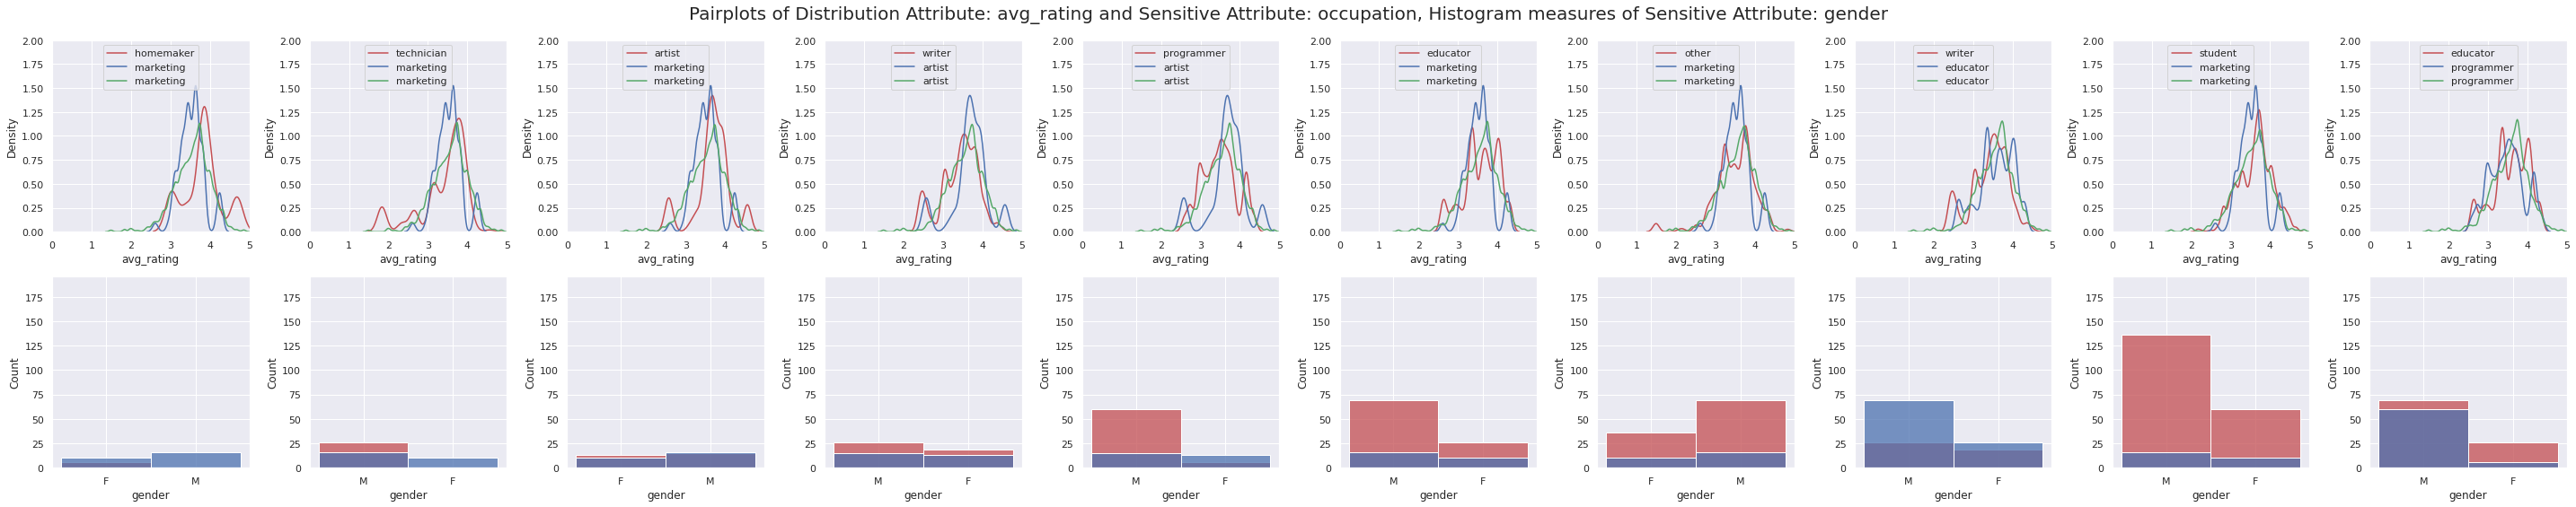

In [55]:
plot_sensitive_attr_distribution_pairs(data=rating_user_item_view,results=results, split_by='gender')

# Conclusions of this notebook

From the findings the the above functions, any dataframe with categorical, and float valued columns can be used to generate a Kolmogorov Sirmnov Test for every pair plot distribution. Only paired distributions that are significantly different are plotted.

Additionally, the limitations of this visual are that the distributions being plotted not also tested to measure the difference from the avg distribution. Reasoning for this is that it is quite easy to measure this metric for any particular categorical attribute, and a particular metric.

Lastly, if there are more that one categorical values presented in the provided dataset. The information plotted can also be split by an additional feature of the dataset to uncover additional unbalanced data

In [ ]:
import seaborn as sns
sns.set()

In [ ]:
sns.pairplot()